In [127]:
# import sys
# sys.path.insert(0, './')
# # sys.path.insert(0, '../')
import rotational_diffusion_photophysics as rdp
import numpy as np
import matplotlib.pyplot as plt

# Maximum l value for SH expansion
# lmax=6 is enough for good accuracy, with reasonable level of saturation.
# At high levels of satuaration use lmax=12 or lmax=20. After that it will be quite slow.
lmax = 12  

# Objective parameters
numerical_aperture = 1.4
refractive_index = 1.518

# Create the illumination scheme
exc488X = rdp.SingleLaser(power_density=1000,
                         wavelength=488,
                         polarization='x',
                         numerical_aperture=numerical_aperture,
                         refractive_index=refractive_index,
                         )

# Create the detectors
detXY = rdp.PolarizedDetection(polarization=['x', 'y'],
                               numerical_aperture=numerical_aperture,
                               refractive_index=refractive_index,
                               )

# Create the fluorophore, with the photophysics
rsEGFP2_100us = rdp.NegativeSwitcher(cross_section_on_blue=2e-18,
                                     lifetime_on=3e-9,
                                     quantum_yield_on_to_off=0.001,
                                     diffusion_coefficient=1/(6*10e-6))

# Full system and experiment
starss2 = rdp.System(illumination=exc488X,
                     fluorophore=rsEGFP2_100us,
                     detection=detXY,
                     lmax=lmax)

# Solve the time evolution and time it for pesrformances
t = np.logspace(-6, -3, 32)
c = starss2.solve(t)

# Compute signals, it includes the analytical solution of the problem
s = starss2.detector_signals(t)
r = rdp.anisotropy(s)

# plt.plot(c[1].T)


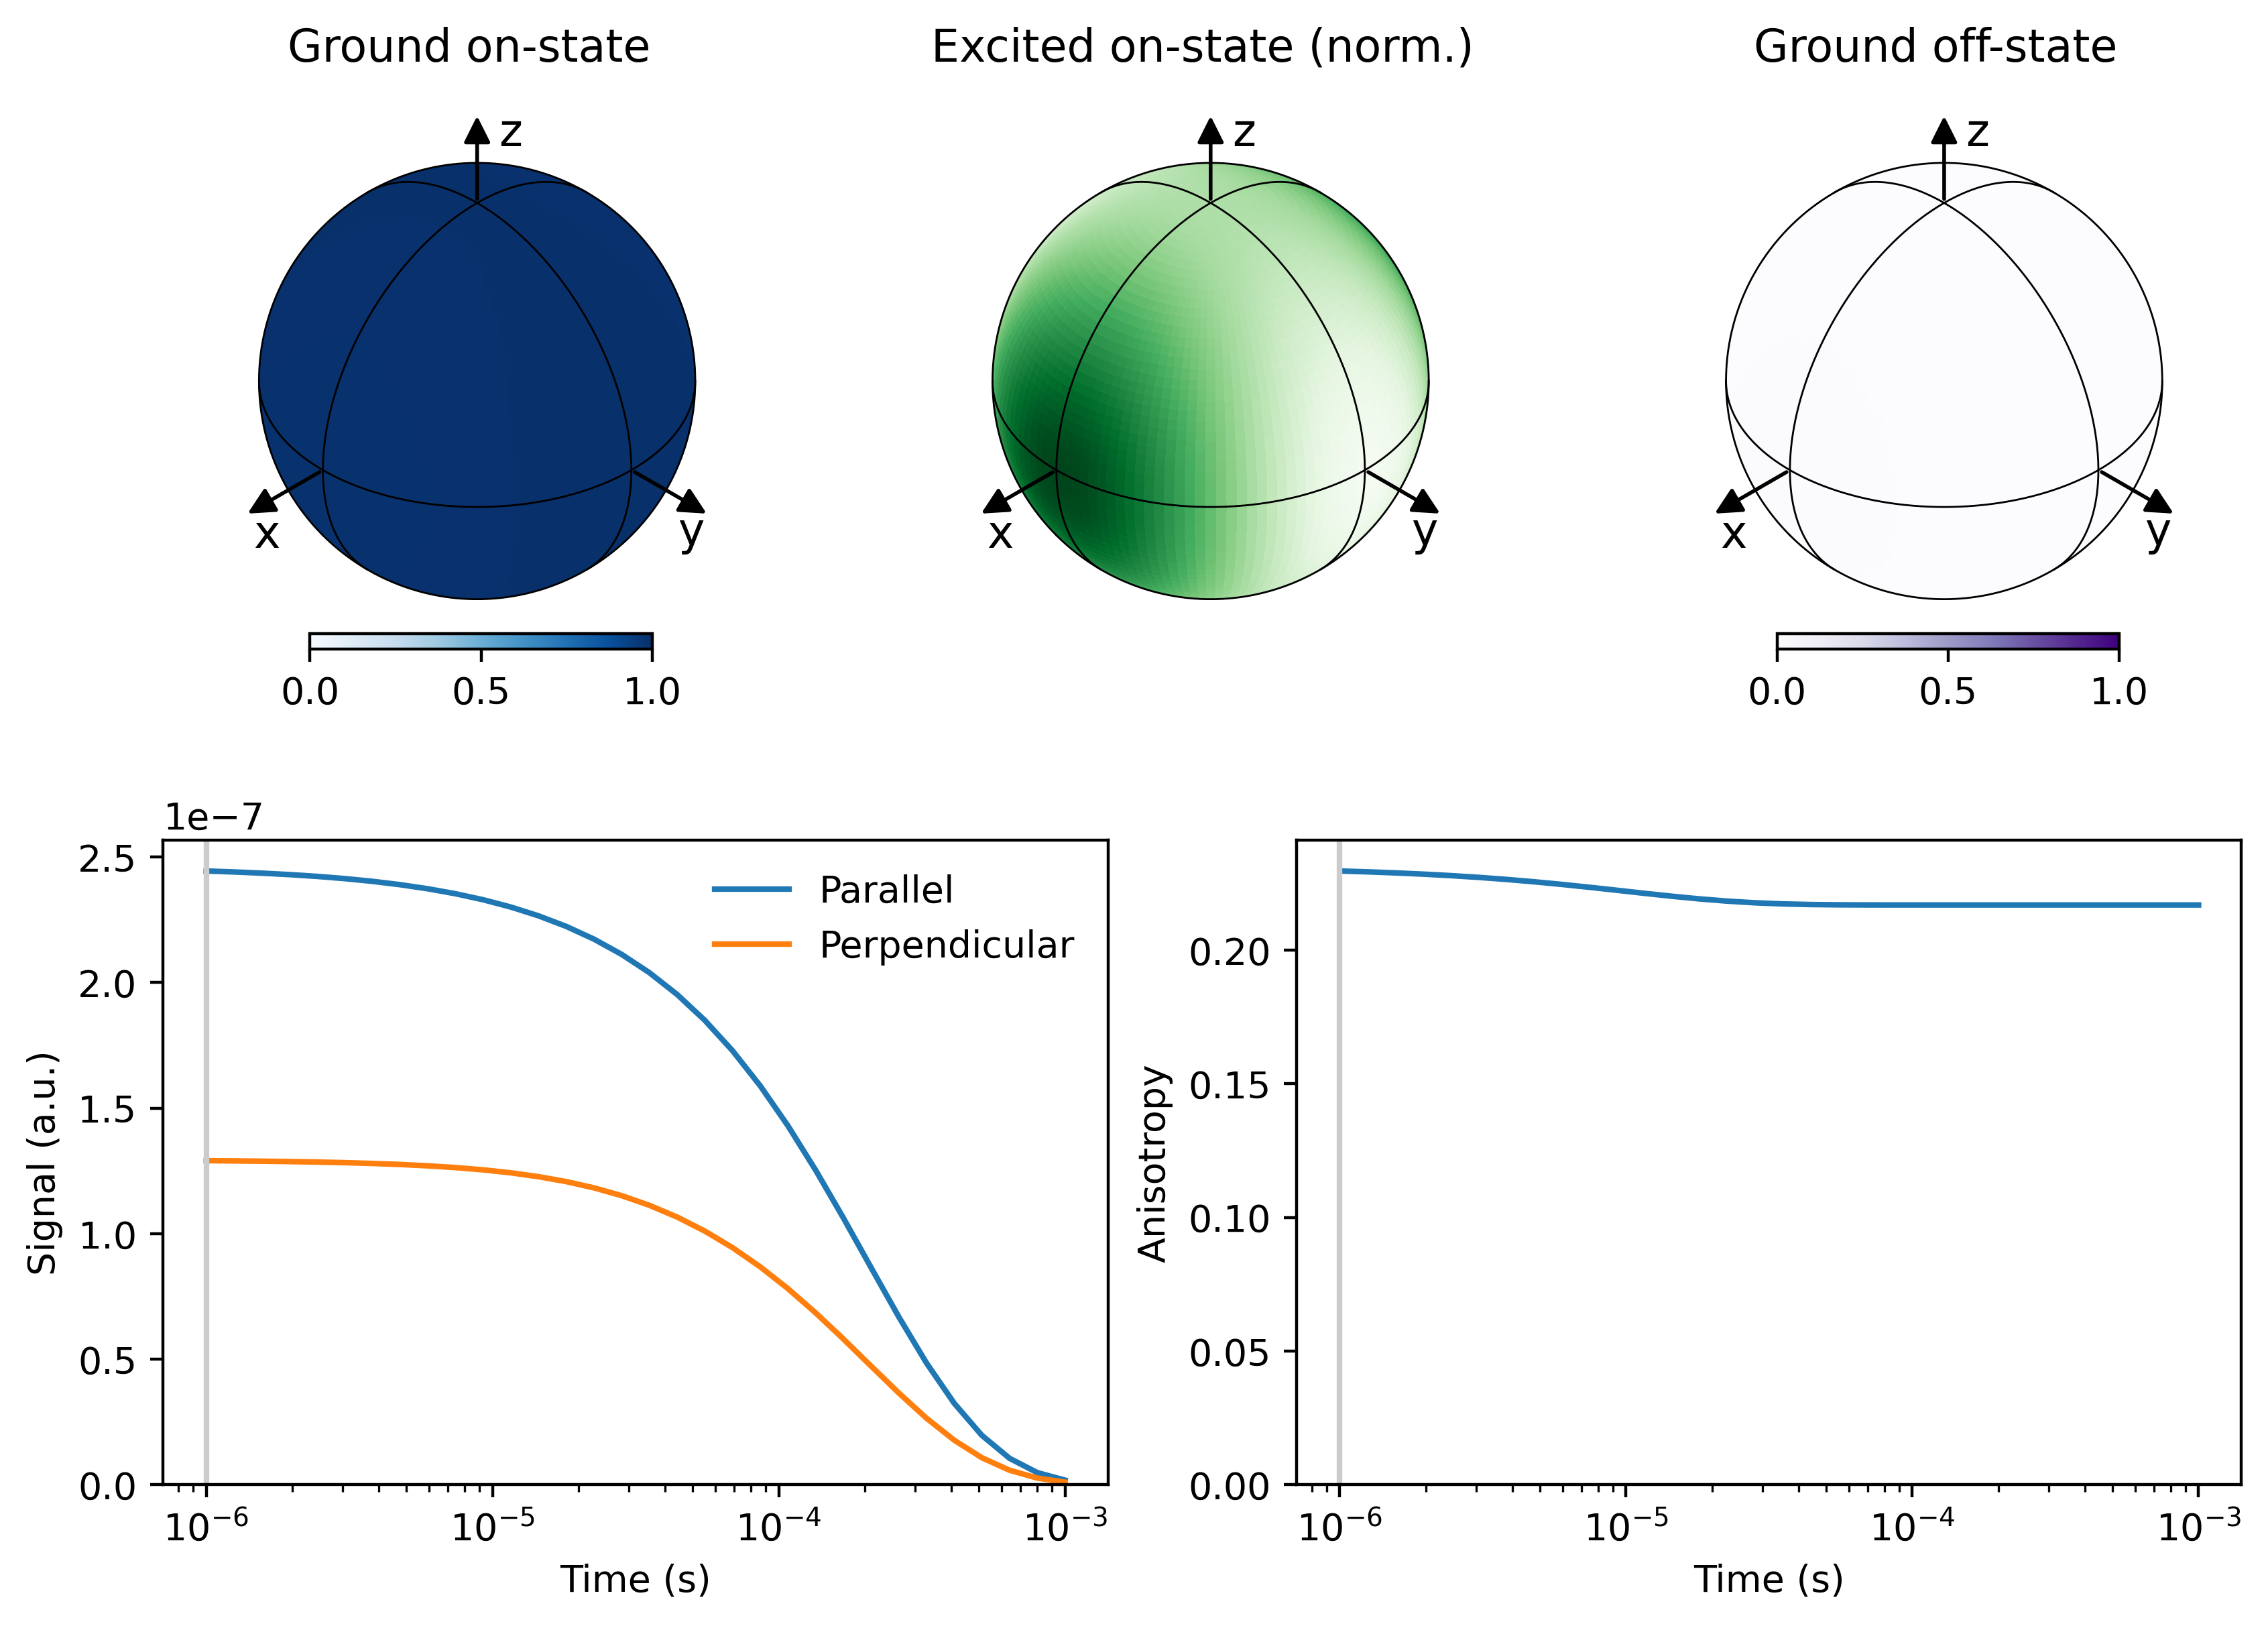

In [125]:
fig = plt.figure(dpi=400, figsize=[10,7])

from plot_data_sphere import plot_data_sphere

ax_sph0 = fig.add_subplot(231, projection='3d') 
ax_sph1 = fig.add_subplot(232, projection='3d') 
ax_sph2 = fig.add_subplot(233, projection='3d')

ax_sph0.set_title('Ground on-state')
ax_sph1.set_title('Excited on-state (norm.)')
ax_sph2.set_title('Ground off-state')

ax1 = fig.add_subplot(223) 
ax2 = fig.add_subplot(224) 

scale = 3
lmax = 32

grid0 = rdp.vec2grid(c[0,:,0], lmax=lmax)
grid1 = rdp.vec2grid(c[1,:,0], lmax=lmax) 
grid2 = rdp.vec2grid(c[2,:,0], lmax=lmax)

cmap0 = plt.cm.Blues
cmap1 = plt.cm.Greens
cmap2 = plt.cm.Purples

sph0 = plot_data_sphere(ax_sph0, grid0.data, scale=scale, cmap=cmap0)
sph1 = plot_data_sphere(ax_sph1, grid1.data, scale=scale, cmap=cmap1, vmax=[], plot_colorbar=False)
sph2 = plot_data_sphere(ax_sph2, grid2.data, scale=scale, cmap=cmap2)

ax1.plot(t, s[0], color='tab:blue')
ax1.plot(t, s[1], color='tab:orange')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal (a.u.)')
ax1.legend(['Parallel', 'Perpendicular'], loc='upper right', frameon=False)
ax1.set_ylim([0, 1.05*np.max(s)])
ax1.set_xscale('log')
line1, = ax1.plot([t[0], t[0]], ax1.get_ylim(), color=[0.8, 0.8, 0.8])

ax2.plot(t, r, color='tab:blue')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Anisotropy')
ax2.set_ylim([0, 1.05*np.max(r)])
ax2.set_xscale('log')
line2, = ax2.plot([t[0], t[0]], ax2.get_ylim(), color=[0.8, 0.8, 0.8])


In [126]:
import matplotlib.animation as animation

plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/andre/Documents/ffmpeg/ffmpeg-4.3.2-2021-02-27-essentials_build/bin/ffmpeg.exe'

def animate(i):
    grid0 = rdp.vec2grid(c[0,:,i], lmax=lmax)
    grid1 = rdp.vec2grid(c[1,:,i], lmax=lmax) 
    grid2 = rdp.vec2grid(c[2,:,i], lmax=lmax)
    
    data0 = grid0.data[0:-1,0:-1].flatten()
    data1 = grid1.data[0:-1,0:-1].flatten(); data1 = data1/np.max(data1)
    data2 = grid2.data[0:-1,0:-1].flatten()

    sph0.set_facecolors(cmap0(data0))
    sph1.set_facecolors(cmap1(data1))
    sph2.set_facecolors(cmap2(data2))

    line1.set_xdata([t[i], t[i]])
    line2.set_xdata([t[i], t[i]])
    return sph0, sph1, sph2, line1, line2

ani = animation.FuncAnimation(
    fig, animate, interval=400, blit=True, save_count=t.size)
ani.save("starss_resolft_2_NA1p4_n1p518_D10us.mp4", bitrate=2000)